## Notebook EDA

## ML Challenge #23 

In [239]:
import json
import pandas as pd

import pandas as pd
train_df = pd.read_json ("data/train.json")
train_df.head()

test_df = pd.read_json ("data/test.json")
test_df.head()

,paperId,title,abstract,year,venue
0,86e1aaa0c47659e08a896e9889384eb1e5401e6a,Exploring the Linear Subspace Hypothesis in Ge...,Bolukbasi et al. (2016) presents one of the fi...,2020,EMNLP
1,8d3076c38f56df22052567f4783c670d8e860f09,HyKnow: End-to-End Task-Oriented Dialog Modeli...,Task-oriented dialog (TOD) systems typically m...,2021,FINDINGS
2,7c400ee676d427eeda1aad5c1c54c316f0b9773d,A Multilingual Information Extraction Pipeline...,We introduce an advanced information extractio...,2018,EMNLP
3,185e7d2a761594451b02ace240356dadad2aef78,Dice Loss for Data-imbalanced NLP Tasks,Many NLP tasks such as tagging and machine rea...,2019,ACL
4,e4363d077a890c8d5c5e66b82fe69a1bbbdd5c80,Attention Guided Graph Convolutional Networks ...,Dependency trees convey rich structural inform...,2019,ACL


Check for missing values

In [240]:
train_df.isna().any().any()

False

Data info (types)

In [241]:
train_df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12129 entries, 0 to 12128
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   paperId     12129 non-null  object
 1   title       12129 non-null  object
 2   authorId    12129 non-null  int64 
 3   authorName  12129 non-null  object
 4   abstract    12129 non-null  object
 5   year        12129 non-null  int64 
 6   venue       12129 non-null  object
dtypes: int64(2), object(5)
memory usage: 663.4+ KB


No empty columms, 7 columns, 12129 rows, types of the variables are seen in Dtype.
POI: Year and AuthorID are loaded as int64, instead of objects.


Check feature stats

In [242]:


z = sum(train_df["authorId"].value_counts() == 1)
x = train_df["authorId"].unique()
z


2207

In [243]:
# """only select authors that occur more than once"""

is_multi =  train_df["authorId"].value_counts() > 1
train_df = train_df[train_df["authorId"].isin(is_multi[is_multi].index)]

In [244]:
z = sum(train_df["authorId"].value_counts() == 1)
z

0

In [245]:
train_df["venue"].value_counts()

ACL                                                                                                              2387
EMNLP                                                                                                            1830
NAACL                                                                                                             862
*SEMEVAL                                                                                                          368
FINDINGS                                                                                                          309
                                                                                                                 ... 
EMNLP 2019                                                                                                          1
Proceedings of the Seventh Workshop on Noisy User-generated Text (W-NUT 2021)                                       1
DLG4NLP                                                 

In [246]:
train_df["year"].value_counts().head(8)


2019    1513
2021    1427
2020    1378
2018    1153
2017     855
2016     852
2015     762
2014     664
Name: year, dtype: int64

Unique Rows

In [247]:
len(train_df.authorId.unique())


3418

In [248]:
len(train_df.title.unique())

9913

In [249]:
len(train_df.abstract.unique())

9918

Number of unique paperId is equal to rows, paperId is main key.

## Check for correlations

In [250]:
from dython.nominal import associations

df = train_df.apply(
    lambda x: x.astype("object") if x.dtype == "int64" else x)
df = df[[i for i in df.columns if i in ('authorId','year','venue')]]


df.head(15)

,authorId,year,venue
0,3188285,2014,CLPsych@ACL
1,2782720,2018,Fig-Lang@NAACL-HLT
3,46331602,2022,ACL
4,30887404,2019,FINDINGS
5,46649145,2019,EMNLP
6,2390150,1995,ACL
8,1696542,2014,WMT@ACL
9,144518416,2017,Rep4NLP@ACL
10,1667898858,2020,ACL
11,2072874946,2021,FINDINGS


In [251]:
from sklearn import preprocessing

label = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame() 

for i in df.columns :
  data_encoded[i]=label.fit_transform(df[i])

data_encoded.head()  

,authorId,year,venue
0,1061,35,56
1,846,39,120
2,2011,43,4
3,1624,40,117
4,2030,40,100


In [252]:
from scipy.stats import chi2_contingency
import numpy as np

def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

rows= []

for var1 in data_encoded:
  col = []
  for var2 in data_encoded :
    cramers =cramers_V(data_encoded[var1], data_encoded[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df2 = pd.DataFrame(cramers_results, columns = data_encoded.columns, index =data_encoded.columns)

df2

,authorId,year,venue
authorId,1.00,0.37,0.38
year,0.37,1.00,0.10
venue,0.38,0.10,1.00


In [253]:
## number of characters in the text 

train_df["num_chars"] = train_df["abstract"].apply(lambda x: len(str(x)))



In [254]:
train_df = train_df.apply(
    lambda x: x.astype("object") if x.dtype == "int64" else x)

test_df = test_df.apply(
    lambda x: x.astype("object") if x.dtype == "int64" else x)

train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9922 entries, 0 to 12127
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   paperId     9922 non-null   object
 1   title       9922 non-null   object
 2   authorId    9922 non-null   object
 3   authorName  9922 non-null   object
 4   abstract    9922 non-null   object
 5   year        9922 non-null   object
 6   venue       9922 non-null   object
 7   num_chars   9922 non-null   object
dtypes: object(8)
memory usage: 697.6+ KB


In [255]:
#import 
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
eng_stopwords = set(stopwords.words("english"))
import string
from collections import Counter

## Number of words in the text ##
train_df["num_words"] = train_df["abstract"].apply(lambda x: round(len(str(x).split())/50)*50)

## Number of unique words in the text ##
train_df["num_unique_words"] = train_df["abstract"].apply(lambda x: round(len(set(str(x).split()))/50)*50)

## Number of characters in the text ##
train_df["num_chars"] = train_df["abstract"].apply(lambda x: round(len(str(x))/100)*100)

## Number of stopwords in the text ##
train_df["num_stopwords"] = train_df["abstract"].apply(lambda x: round(len([w for w in str(x).lower().split() if w in eng_stopwords])/10)*10)

## Number of punctuations in the text ##
train_df["num_punctuations"] =train_df['abstract'].apply(lambda x: round(len([c for c in str(x) if c in string.punctuation])/10)*10)

## Number of title case words in the text ##
train_df["num_words_upper"] = train_df["abstract"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train_df["num_words_title"] = train_df["abstract"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
train_df["mean_word_len"] = train_df["abstract"].apply(lambda x: round(np.mean([len(w) for w in str(x).split()])/1)*1)


#---------------------- TEST ---------------------------

## Number of words in the text ##
test_df["num_words"] = test_df["abstract"].apply(lambda x: round(len(str(x).split())/50)*50)

## Number of unique words in the text ##
test_df["num_unique_words"] = test_df["abstract"].apply(lambda x: round(len(set(str(x).split()))/50)*50)

## Number of characters in the text ##
test_df["num_chars"] = test_df["abstract"].apply(lambda x: round(len(str(x))/100)*100)

## Number of stopwords in the text ##
test_df["num_stopwords"] = test_df["abstract"].apply(lambda x: round(len([w for w in str(x).lower().split() if w in eng_stopwords])/10)*10)

## Number of punctuations in the text ##
test_df["num_punctuations"] =test_df['abstract'].apply(lambda x: round(len([c for c in str(x) if c in string.punctuation])/10)*10)

## Number of title case words in the text ##
test_df["num_words_upper"] = test_df["abstract"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
test_df["num_words_title"] = test_df["abstract"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
test_df["mean_word_len"] = test_df["abstract"].apply(lambda x: round(np.mean([len(w) for w in str(x).split()])/1)*1)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dprin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [256]:
train_df["abstract"]

0        Children with autism spectrum disorder often e...
1        We present and compare two alternative deep ne...
3        Coreference resolution over semantic graphs li...
4        In this paper, we present Linguistics Informed...
5        Event detection (ED) aims to locate trigger wo...
                               ...                        
12123    We apply a decision tree based approach to pro...
12124    The de-facto standard decoding method for sema...
12125    This is a report on the methods used and resul...
12126    We describe the second IWPT task on end-to-end...
12127    Abstract This paper investigates the ability o...
Name: abstract, Length: 9922, dtype: object

In [257]:
train_id = train_df['authorId'].values

### recompute the trauncated variables again ###
train_df["num_words"] = train_df["abstract"].apply(lambda x: round(len(str(x).split())/25)*25)
train_df["mean_word_len"] = train_df["abstract"].apply(lambda x: round(np.mean([len(w) for w in str(x).split()])/1)*1)

test_df["num_words"] = test_df["abstract"].apply(lambda x: round(len(str(x).split())/25)*25)
test_df["mean_word_len"] = test_df["abstract"].apply(lambda x: round(np.mean([len(w) for w in str(x).split()])/1)*1)



cols_to_drop = ['authorId', 'abstract']

In [258]:
##

C:\Users\dprin\AppData\Local\Temp\ipykernel_9180\2275619544.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['num_words'].loc[train_df['num_words']>300] = 300 #truncation for better visuals


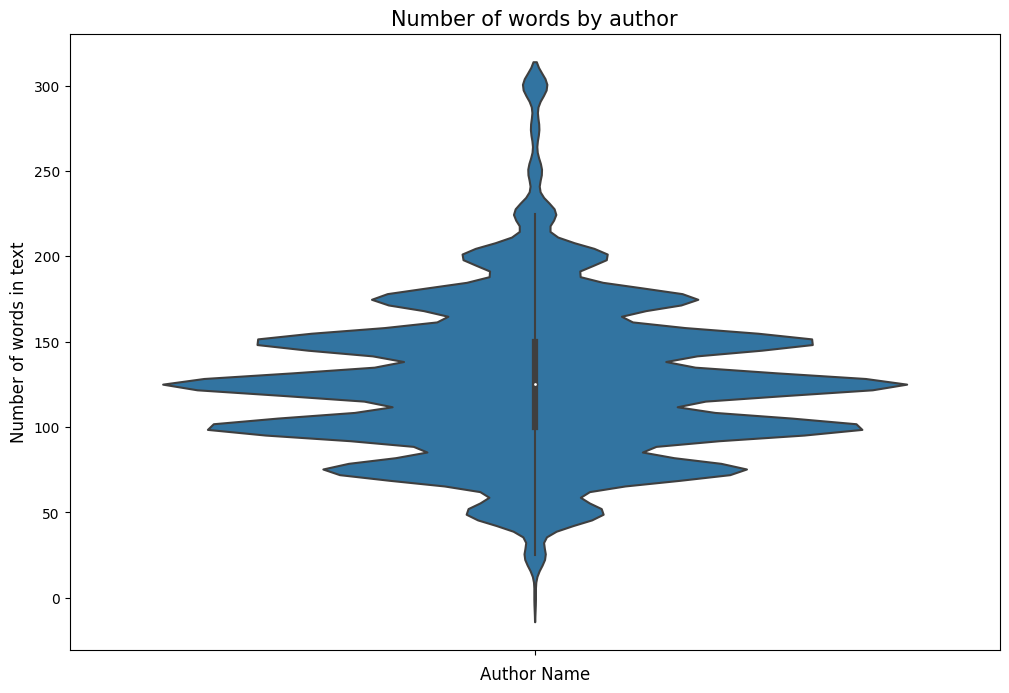

In [259]:
import matplotlib.pyplot as plt
import seaborn as sns

train_df['num_words'].loc[train_df['num_words']>300] = 300 #truncation for better visuals
plt.figure(figsize=(12,8))
sns.violinplot(y='num_words', data=train_df)
plt.xlabel('Author Name', fontsize=12)
plt.ylabel('Number of words in text', fontsize=12)
plt.title("Number of words by author", fontsize=15)
plt.show()

In [260]:
import string
from nltk.corpus import stopwords
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

stopwords = set(stopwords.words("english"))
words = ("pp", "method", "paper", "task", "present")


train_df['abstractClean'] = train_df['abstract'].str.replace('[^[a-zA-Z0-9-]*$]',' ')
train_df['abstractClean'] = train_df['abstractClean'].str.lower()
train_df["abstractClean"] = train_df["abstractClean"].str.strip()
train_df["abstractClean"] = train_df["abstractClean"].str.split()  
train_df['abstractClean'] = train_df['abstractClean'].apply(lambda x: ' '.join([word for word in x if word not in stopwords]))


train_df['titleClean'] = train_df['title'].str.replace('[^[a-zA-Z0-9-]*$]',' ')
train_df['titleClean'] = train_df['titleClean'].str.lower()
train_df["titleClean"] = train_df["titleClean"].str.strip()
train_df["titleClean"] = train_df["titleClean"].str.split()
train_df['titleClean'] = train_df['titleClean'].apply(lambda x: ' '.join([word for word in x if word not in stopwords]))


train_df.head(5)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dprin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\dprin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dprin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
C:\Users\dprin\AppData\Local\Temp\ipykernel_9180\1523786658.py:13: FutureWarning: The default value of regex will change from True to False in a future version.
  train_df['abstractClean'] = train_df['abstract'].str.replace('[^[a-zA-Z0-9-]*$]',' ')
C:\Users\dprin\AppData\Local\Temp\ipykernel_9180\1523786658.py:20: FutureWarning: The default value of regex will change from True to False in a future version.
  train_df['titleClean'] = train_df['title'].str.replace('[^[a-zA-Z0-9-]*$]',' ')


,paperId,title,authorId,authorName,abstract,year,venue,num_chars,num_words,num_unique_words,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len,abstractClean,titleClean
0,0b341b6938308a6d5f47edf490f6e46eae3835fa,Detecting linguistic idiosyncratic interests i...,3188285,Masoud Rouhizadeh,Children with autism spectrum disorder often e...,2014,CLPsych@ACL,900,150,100,60,10,0,5,6,children autism spectrum disorder often exhibi...,detecting linguistic idiosyncratic interests a...
1,c682727ee058aadbe9dbf838dcb036322818f588,Bigrams and BiLSTMs Two Neural Networks for Se...,2782720,Yuri Bizzoni,We present and compare two alternative deep ne...,2018,Fig-Lang@NAACL-HLT,400,50,50,20,10,0,2,6,present compare two alternative deep neural ar...,bigrams bilstms two neural networks sequential...
3,7e8b4cfdc03b59ece2d6b33a217f0abd47f708d9,Variational Graph Autoencoding as Cheap Superv...,46331602,Irene Li,Coreference resolution over semantic graphs li...,2022,ACL,800,125,100,40,20,7,8,6,coreference resolution semantic graphs like am...,variational graph autoencoding cheap supervisi...
4,07588dd5d0252c7abc99b3834a81bf23741ead4b,LIMIT-BERT : Linguistics Informed Multi-Task BERT,30887404,Junru Zhou,"In this paper, we present Linguistics Informed...",2019,FINDINGS,1300,175,100,50,40,14,18,6,"paper, present linguistics informed multi-task...",limit-bert : linguistics informed multi-task bert
5,b3f238fad54ec008a69d3f2777dd25d658425f5d,Event Detection with Trigger-Aware Lattice Neu...,46649145,Ning Ding,Event detection (ED) aims to locate trigger wo...,2019,EMNLP,1300,200,150,60,60,2,14,5,event detection (ed) aims locate trigger words...,event detection trigger-aware lattice neural n...


In [261]:
#TEST

test_df['abstractClean'] = test_df['abstract'].str.replace('[^[a-zA-Z0-9-]*$]',' ')
test_df['abstractClean'] = test_df['abstractClean'].str.lower()
test_df["abstractClean"] = test_df["abstractClean"].str.strip()
test_df["abstractClean"] = test_df["abstractClean"].str.split()  
#test_df['abstractClean'] = test_df['abstractClean'].apply(lambda x: ' '.join([word for word in x if word not in stopwords]))
test_df['abstractClean'] = test_df['abstractClean'].apply(lambda x: ' '.join([word for word in x]))



test_df['titleClean'] = test_df['title'].str.replace('[^[a-zA-Z0-9-]*$]',' ')
test_df['titleClean'] = test_df['titleClean'].str.lower()
test_df["titleClean"] = test_df["titleClean"].str.strip()
test_df["titleClean"] = test_df["titleClean"].str.split()
#test_df['titleClean'] = test_df['titleClean'].apply(lambda x: ' '.join([word for word in x if word not in stopwords]))
test_df['titleClean'] = test_df['titleClean'].apply(lambda x: ' '.join([word for word in x]))

test_df.head(5)

C:\Users\dprin\AppData\Local\Temp\ipykernel_9180\3764310979.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_df['abstractClean'] = test_df['abstract'].str.replace('[^[a-zA-Z0-9-]*$]',' ')
C:\Users\dprin\AppData\Local\Temp\ipykernel_9180\3764310979.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  test_df['titleClean'] = test_df['title'].str.replace('[^[a-zA-Z0-9-]*$]',' ')


,paperId,title,abstract,year,venue,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len,abstractClean,titleClean
0,86e1aaa0c47659e08a896e9889384eb1e5401e6a,Exploring the Linear Subspace Hypothesis in Ge...,Bolukbasi et al. (2016) presents one of the fi...,2020,EMNLP,150,100,1000,60,20,0,9,5,bolukbasi et al. (2016) presents one of the fi...,exploring the linear subspace hypothesis in ge...
1,8d3076c38f56df22052567f4783c670d8e860f09,HyKnow: End-to-End Task-Oriented Dialog Modeli...,Task-oriented dialog (TOD) systems typically m...,2021,FINDINGS,150,100,1000,40,30,4,7,6,task-oriented dialog (tod) systems typically m...,hyknow: end-to-end task-oriented dialog modeli...
2,7c400ee676d427eeda1aad5c1c54c316f0b9773d,A Multilingual Information Extraction Pipeline...,We introduce an advanced information extractio...,2018,EMNLP,100,100,600,30,10,0,9,6,we introduce an advanced information extractio...,a multilingual information extraction pipeline...
3,185e7d2a761594451b02ace240356dadad2aef78,Dice Loss for Data-imbalanced NLP Tasks,Many NLP tasks such as tagging and machine rea...,2019,ACL,250,150,1600,90,40,12,12,6,many nlp tasks such as tagging and machine rea...,dice loss for data-imbalanced nlp tasks
4,e4363d077a890c8d5c5e66b82fe69a1bbbdd5c80,Attention Guided Graph Convolutional Networks ...,Dependency trees convey rich structural inform...,2019,ACL,150,100,1100,40,20,0,11,6,dependency trees convey rich structural inform...,attention guided graph convolutional networks ...


In [262]:
# add lemmer
lemmer = nltk.WordNetLemmatizer()
train_df["abstractCleanLem"] = train_df["abstractClean"].str.split()  
train_df["abstractCleanLem"] = train_df["abstractCleanLem"].apply(lambda x: ' '.join([lemmer.lemmatize(word) for word in x]))

train_df["titleCleanLem"] = train_df["titleClean"].str.split()  
train_df["titleCleanLem"] = train_df["titleCleanLem"].apply(lambda x: ' '.join([lemmer.lemmatize(word) for word in x]))

train_df["abstractCleanLem"][1]

##train_df.to_csv("output.csv")

'present compare two alternative deep neural architecture perform word-level metaphor detection text: bi-lstm model new structure based recursive feed-forward concatenation input. discus different version model effect input manipulation - specifically, reducing length sentence introducing concreteness score word - performance.'

In [263]:
# add lemmer
lemmer = nltk.WordNetLemmatizer()
test_df["abstractCleanLem"] = test_df["abstractClean"].str.split()  
test_df["abstractCleanLem"] = test_df["abstractCleanLem"].apply(lambda x: ' '.join([lemmer.lemmatize(word) for word in x]))

test_df["titleCleanLem"] = test_df["titleClean"].str.split()  
test_df["titleCleanLem"] = test_df["titleCleanLem"].apply(lambda x: ' '.join([lemmer.lemmatize(word) for word in x]))

test_df["abstractCleanLem"][1]
##train_df.to_csv("output.csv")

'task-oriented dialog (tod) system typically manage structured knowledge (e.g. ontology and databases) to guide the goal-oriented conversations. however, they fall short of handling dialog turn grounded on unstructured knowledge (e.g. review and documents). in this paper, we formulate a task of modeling tod grounded on both structured and unstructured knowledge. to address this task, we propose a tod system with hybrid knowledge management, hyknow. it extends the belief state to manage both structured and unstructured knowledge, and is the first end-to-end model that jointly optimizes dialog modeling grounded on these two kind of knowledge. we conduct experiment on the modified version of multiwoz 2.1 dataset, where dialog are grounded on hybrid knowledge. experimental result show that hyknow ha strong end-to-end performance compared to existing tod systems. it also outperforms the pipeline knowledge management schemes, with higher unstructured knowledge retrieval accuracy.'

In [264]:
#add stemmer
#stemmer = nltk.stem.PorterStemmer()
#train_df["abstractCleanStem"] = train_df["abstractCleanLem"].str.split()  
#train_df["abstractCleanStem"] = train_df["abstractCleanStem"].apply(lambda x: ' '.join([stemmer.stem(word) for word in x]))


#Removed stemmer

#from nltk.tokenize import word_tokenize
#tokenizer = word_tokenize()
#words = qword_tokenizer.tokenize(sample_txt)
#print(words)

#removed tokenizer



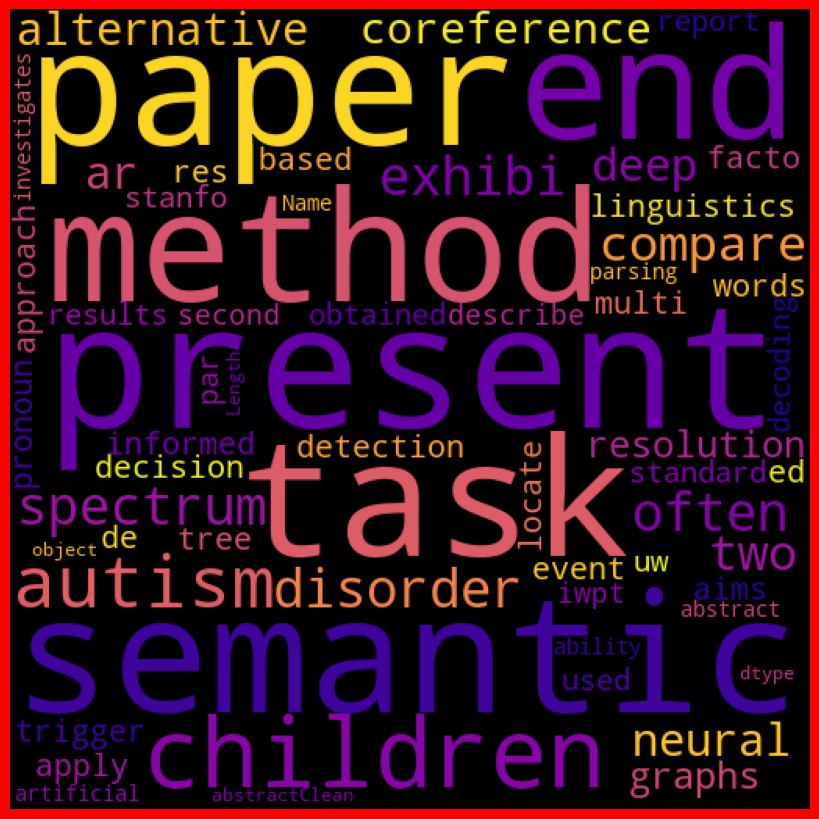

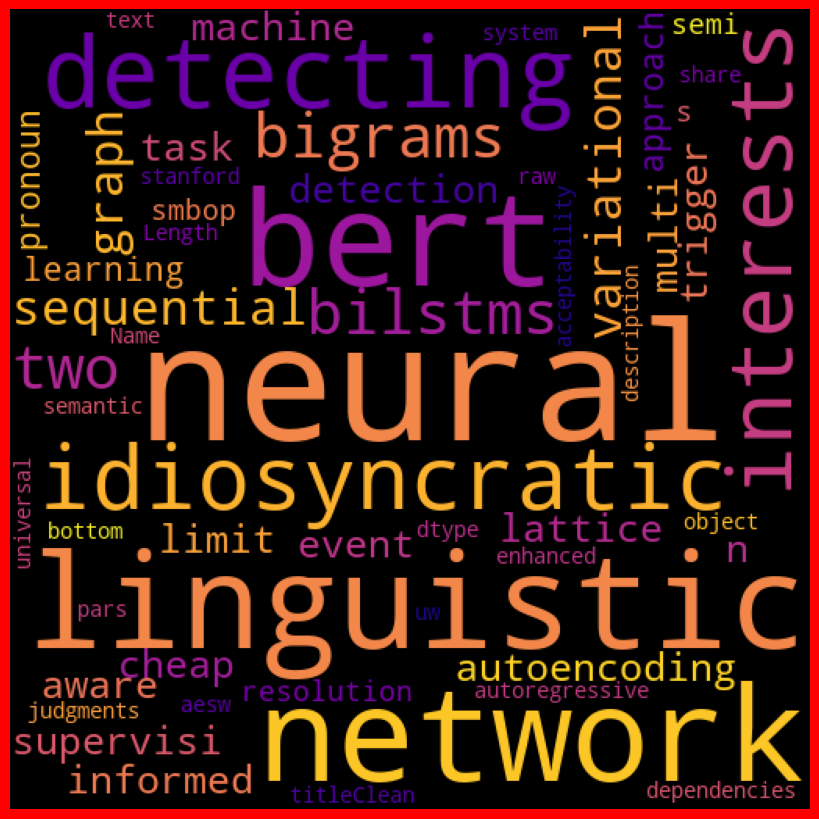

In [265]:
from wordcloud import WordCloud

train_wc = str(train_df["abstractClean"])
train_wc_title = str(train_df["titleClean"])

train_wc = WordCloud(width = 512, height = 512, colormap = 'plasma').generate(train_wc)
train_wc_title = WordCloud(width = 512, height = 512, colormap = 'plasma').generate(train_wc_title)



plt.figure(figsize = (10,8), facecolor = 'r')
plt.imshow(train_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

plt.figure(figsize = (10,8), facecolor = 'r')
plt.imshow(train_wc_title)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()



#

In [266]:

#Train test split
#train_df, validation_df = train_test_split(train_df, test_size=0.2)

#test_id = validation_df['authorId'].values

#train_X = train_df.drop(cols_to_drop+['authorName'], axis=1)
#validation_X = validation_df.drop(cols_to_drop, axis=1)

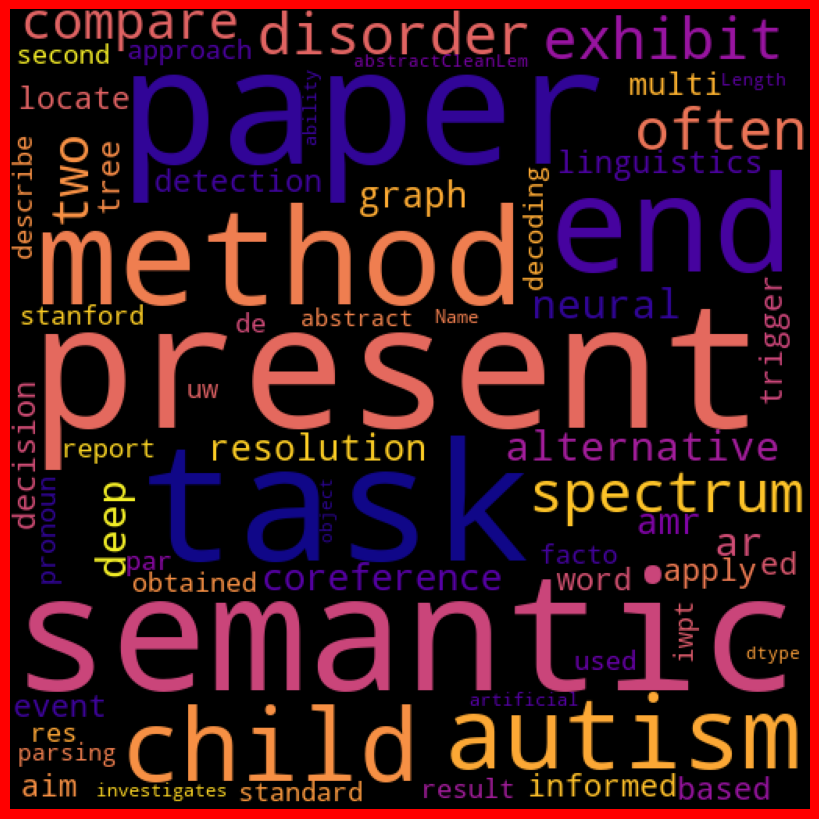

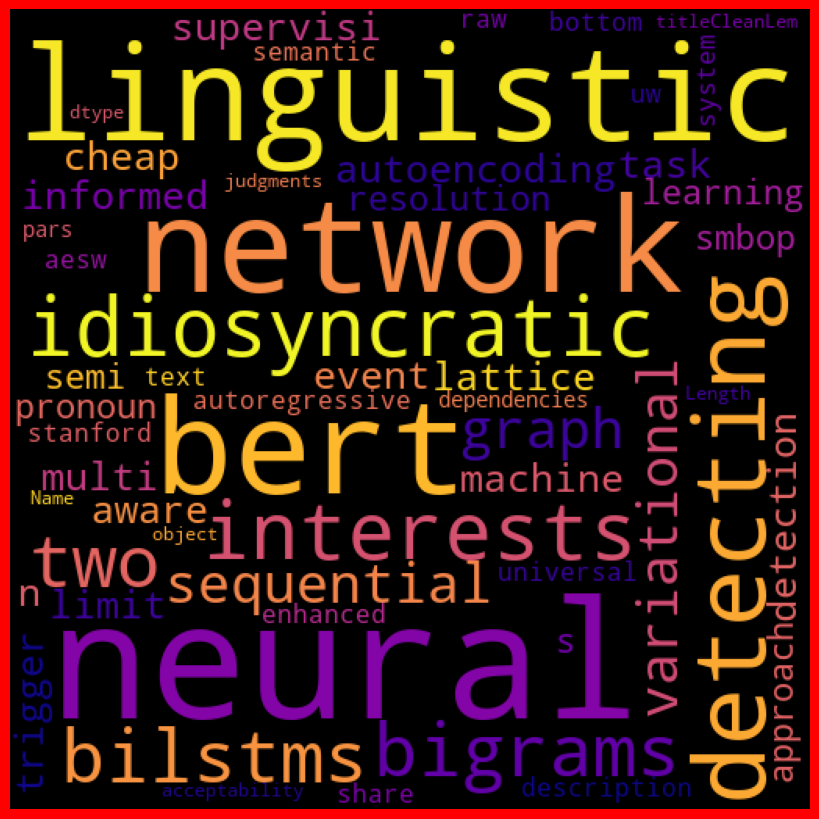

In [267]:
words = ()#"method", "paper", "task", "present", "aim", "end", "paper", "often", "text")
train_df["titleCleanLem"] = train_df["titleClean"].str.split()  
train_df['titleCleanLem'] = train_df['titleCleanLem'].apply(lambda x: ' '.join([word for word in x if word not in words]))

train_df["abstractCleanLem"] = train_df["abstractCleanLem"].str.split()  
train_df['abstractCleanLem'] = train_df['abstractCleanLem'].apply(lambda x: ' '.join([word for word in x if word not in words]))

from wordcloud import WordCloud

train_wc = str(train_df["abstractCleanLem"])
train_wc_title = str(train_df["titleCleanLem"])

train_wc = WordCloud(width = 512, height = 512, colormap = 'plasma').generate(train_wc)
train_wc_title = WordCloud(width = 512, height = 512, colormap = 'plasma').generate(train_wc_title)



plt.figure(figsize = (10,8), facecolor = 'r')
plt.imshow(train_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

plt.figure(figsize = (10,8), facecolor = 'r')
plt.imshow(train_wc_title)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()


In [295]:
tmp = " "

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
from sklearn.preprocessing import label_binarize


# Create Label Encoder
#y = le.fit_transform(train_df.authorId) # Set Labels (ham, spam) -> (0, 1)
y = train_df["authorId"].values.astype(str)
#year	venue	num_chars	num_words	num_unique_words	num_stopwords	num_punctuations	num_words_upper	num_words_title	mean_word_len
train_df["Input Data"] = train_df['year'].astype(str) + " " + train_df['venue'].astype(str) + " " + train_df['abstractCleanLem'] + " " + train_df['titleCleanLem'] + " " + train_df['num_chars'].astype(str) + " " + train_df['num_unique_words'].astype(str) + " " + train_df['num_punctuations'].astype(str) + " " + train_df['mean_word_len'].astype(str) + " " + train_df['num_stopwords'].astype(str) +  " " + train_df['num_words'].astype(str)
train_df_authorId = train_df['authorId'].to_numpy()
train_df_abstractClean = train_df['abstractCleanLem'].to_numpy()
train_df_titleClean = train_df['titleCleanLem'].to_numpy()
train_df_Input_Data = train_df['Input Data'].to_numpy()
##train_df_most_common = train_df['most_common'].to_numpy()

train_df["InputNotClean"] = train_df['venue'].astype(str) + " " + train_df['abstract'] + " " + train_df['title'] + " " + train_df['num_unique_words'].astype(str) + " " + train_df['num_punctuations'].astype(str) + " " + train_df['mean_word_len'].astype(str) + " " + train_df['num_stopwords'].astype(str) +  " " + train_df['num_words'].astype(str)
train_df_Input_Data_Not_Clean = train_df['InputNotClean'].to_numpy()

X_train, X_valid, Y_train, Y_valid = train_test_split(train_df_Input_Data_Not_Clean, y, stratify = y, test_size=0.35,  random_state=123, shuffle= True)

# X_train = train_df_Input_Data
# Y_train = y
X_train





array(['TACL Answer sentence ranking and answer extraction are two key challenges in question answering that have traditionally been treated in isolation, i.e., as independent tasks. In this article, we (1) explain how both tasks are related at their core by a common quantity, and (2) propose a simple and intuitive joint probabilistic model that addresses both via joint computation but task-specific application of that quantity. In our experiments with two TREC datasets, our joint model substantially outperforms state-of-the-art systems in both tasks. A Joint Model for Answer Sentence Ranking and Answer Extraction 50 20 6 30 75',
       "CL Frame semantics is a linguistic theory that has been instantiated for English in the FrameNet lexicon. We solve the problem of frame-semantic parsing using a two-stage statistical model that takes lexical targets (i.e., content words and phrases) in their sentential contexts and predicts frame-semantic structures. Given a target in context, the firs

In [296]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
from sklearn.preprocessing import label_binarize


# Create Label Encoder
#y = le.fit_transform(train_df.authorId) # Set Labels (ham, spam) -> (0, 1)
test_df["Input Data"] = test_df['year'].astype(str) + " " + test_df['venue'].astype(str) + " " + test_df['abstractCleanLem'] + " " + test_df['titleCleanLem']  + " " +  train_df['num_chars'].astype(str) + " " + train_df['num_unique_words'].astype(str) + " " + train_df['num_punctuations'].astype(str) + " " + train_df['mean_word_len'].astype(str) + " " + train_df['num_stopwords'].astype(str) +  " " + test_df['num_words'].astype(str)
test_df["authorId"] = ""
test_df_abstractClean = test_df['abstractCleanLem'].to_numpy()
test_df_titleClean = test_df['titleCleanLem'].to_numpy()
test_df_Input_Data = test_df['Input Data'].to_numpy()
##test_df_most_common = test_df['most_common'].to_numpy()

test_df["InputNotClean"] = test_df['venue'].astype(str) + " " + test_df['abstract'] + " " + test_df['title'] + " " + test_df['num_unique_words'].astype(str) + " " + test_df['num_punctuations'].astype(str) + " " + test_df['mean_word_len'].astype(str) + " " + test_df['num_stopwords'].astype(str) +  " " + test_df['num_words'].astype(str)
test_df_Input_Data_Not_Clean = test_df['InputNotClean'].to_numpy()


X_testdata = test_df_Input_Data
test_df_Input_Data




array(['2020 EMNLP bolukbasi et al. (2016) present one of the first gender bias mitigation technique for word embeddings. their method take pre-trained word embeddings a input and attempt to isolate a linear subspace that capture most of the gender bias in the embeddings. a judged by an analogical evaluation task, their method virtually eliminates gender bias in the embeddings. however, an implicit and untested assumption of their method is that the bias sub-space is actually linear. in this work, we generalize their method to a kernelized, non-linear version. we take inspiration from kernel principal component analysis and derive a non-linear bias isolation technique. we discus and overcome some of the practical drawback of our method for non-linear gender bias mitigation in word embeddings and analyze empirically whether the bias subspace is actually linear. our analysis show that gender bias is in fact well captured by a linear subspace, justifying the assumption of bolukbasi et al.

In [297]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer(ngram_range=(1,5))
X_train_counts = count_vect.fit_transform(X_train)

count_vect.vocabulary_.get(u'algorithm')

75603

In [298]:
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_counts)
X_train_tfidf = tf_transformer.transform(X_train_counts)

X_train_tfidf.shape



(6449, 2616345)

In [353]:
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB # Naive Bayes
from sklearn.svm import LinearSVC, SVC # Support Vector Machine
from sklearn.ensemble import RandomForestClassifier # Random Forest
import time
from sklearn.neighbors import KNeighborsClassifier # Random Forest
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix, make_scorer, adjusted_rand_score, silhouette_score, homogeneity_score, normalized_mutual_info_score


text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    # ('clf', SGDClassifier(loss='hinge', penalty='l2',
    #                        alpha=0.0001, random_state=43,
    #                        max_iter=500, n_jobs =-1, tol= 1e-6, learning_rate = 'optimal', eta0 = 1, shuffle = True, fit_intercept = True)),
    ('classifier', XGBClassifier(nthread=12, random_state = 42, verbosity =1, n_estimators = 400, learning_rate = 0.1, max_depth = 3 ))
   # ("svm_clf", LinearSVC(tol=1e-3, fit_intercept = True, multi_class = "crammer_singer", C = 1e-1, dual = True, loss = 'squared_hinge'))
    #("svm_clf", BaggingClassifier(DecisionTreeClassifier(splitter='random', max_leaf_nodes=40), n_estimators=50, max_samples=1.0, bootstrap=True, n_jobs=-1))
    #('clf', LogisticRegression(n_jobs=-1, multi_class = 'auto', random_state=42, penalty = 'l2', solver = 'saga', class_weight= 'balanced', max_iter = 100, warm_start = False, fit_intercept= True)),
])


text_clf.fit(X_train, Y_train)
#importance = text_clf.named_steps['clf'].coef_


In [351]:
predicted = text_clf.predict(X_valid)

np.mean(predicted == Y_valid)

# Get test accuracy
test = text_clf.score(X=X_valid,y=Y_valid)
print("\nTest Accuracy Score:",test)

test = text_clf.score(X=X_train, y=Y_train)
print("\nTrain Accuracy Score:",test)

y_pred = text_clf.predict(X_valid)

ari = adjusted_rand_score(Y_valid, y_pred)
print("\nAdjusted Rand-Index: %.3f" % ari)

hom = homogeneity_score(Y_valid,y_pred)
print("Homogeneity Score: %.3f" % hom)

nmi = normalized_mutual_info_score(Y_valid,y_pred)
print("Normed Mutual-Info Score: %.3f" % nmi)


Test Accuracy Score: 0.17333717247336597

Train Accuracy Score: 1.0

Adjusted Rand-Index: 0.028
Homogeneity Score: 0.899
Normed Mutual-Info Score: 0.936


In [352]:
predictions = text_clf.predict(X_testdata)
#predictions = list(le.inverse_transform(predictedTEST))

predictions[:10]


ValueError: np.nan is an invalid document, expected byte or unicode string.

In [ ]:
import json
from sklearn.metrics import accuracy_score
import numpy as np
from collections import OrderedDict, defaultdict


tmp = pd.read_json ("data/test.json")
predicted = pd.DataFrame({'paperId' : [], 'authorId' : []})
predicted["paperId"], predicted["authorId"] = tmp["paperId"], predictions

predicted.head(5)

l = predicted.to_dict(orient = "records", into = OrderedDict())

l
with open("predicted.json", "w") as file:
    json.dump(l, file, indent =4)


NameError: name 'predictions' is not defined

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid  = {"LinearSVC__multi_class": ["ovr", "crammer_singer"],
                "LinearSVC__penalty": ['l2'],
                "LinearSVC__loss": ['hinge', 'squared_hinge'],
                "LinearSVC__fit_intercept": [True, False],
                "LinearSVC__tol": [1e-2],
                "LinearSVC__C": [0.5,0.75,0.85,0.95, 1, 1.25, 1.5]} 

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('LinearSVC', LinearSVC())])


Gridsearch = RandomizedSearchCV(estimator = text_clf, n_iter= 1000, param_distributions = param_grid, verbose = 1, cv = 2)


Gridsearchresult = Gridsearch.fit(X_train, Y_train)
print('optimal score: ', Gridsearch.best_score_)
print('optimal score: ', Gridsearch.best_params_)

c:\Users\dprin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 56 is smaller than n_iter=1000. Running 56 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\dprin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


Fitting 2 folds for each of 56 candidates, totalling 112 fits


c:\Users\dprin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\dprin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_grid  = {"SGDClassifier__loss": ['log_loss', 'perceptron', 'hinge', ],
                "SGDClassifier__penalty": ['l2'],
                "SGDClassifier__alpha": [1e-3, 1e-2, 1e-1, 1, 10],
                "SGDClassifier__learning_rate": ['constant', 'optimal', 'adaptive'],
                "SGDClassifier__eta0": [0.01, 0.05, 0.1, 1, 10, 100]} 

SGDmodel = SGDClassifier()

text_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('SGDClassifier', SGDClassifier(tol= 1e-6))])

Gridsearch = RandomizedSearchCV(estimator = text_clf, n_jobs = -1, n_iter= 200, param_distributions = param_grid, verbose = 1, cv = 2)


Gridsearchresult = Gridsearch.fit(X_train, Y_train)
print('optimal score: ', Gridsearch.best_score_)
print('optimal score: ', Gridsearch.best_params_)

Fitting 2 folds for each of 200 candidates, totalling 400 fits


c:\Users\dprin\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:684: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(
